## 1 IMDB数据集介绍

本节使用IMDB数据集，它包含来自互联网电影数据库（IMDB）的50000条严重两极分化的评论。数据集被分为用于训练的25000条评论与用于测试的25000条评论，训练集和测试集都包含50%的正面评论和50%的负面评论。

与MNIST数据集一样，IMDB数据集也内置于Keras库。它已经过预处理：评论（单词序列）已经被转换为整数序列，其中每个整数代表字典中的某个单词。

In [16]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

* 参数`num_words=10000`的意思是仅保留训练数据中前`10000`个最常出现的单词。低频单词将被舍弃。这样得到的向量数据不会太大，便于处理。

* `train_data`和`test_data`这两个变量都是评论组成的列表，每条评论又是单词索引组成的列表（表示一系列单词）。 `train_labels`和`test_labels`都是 0 和 1 组成的列表，其中 0代表负面（negative）， 1 代表正面（positive）。

In [17]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [18]:
train_data[0:2]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [19]:
train_labels

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [20]:
# 由于限定为前10000个最常见的单词，单词索引都不会超过10000
max([max(sequence) for sequence in train_data])

9999

In [21]:
# 将某条评论迅速解码为英文单词

# word_index 是一个将单词映射为整数索引的字典
word_index = imdb.get_word_index()
# 键值颠倒，将整数索引映射为单词
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 将评论解码。注意，索引减去了 3，
# 因为 0、 1、 2是为“padding”（填充）、
#“start of sequence”（序列开始）、
# “unknown”（未知词）分别保留的索引
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

# 2 准备数据

你不能将整数序列直接输入神经网络。你需要将列表转换为张量。转换方法有以下两种。

* 填充列表，使其具有相同的长度，再将列表转换成形状为 `(samples, word_indices)`的整数张量，然后网络第一层使用能处理这种整数张量的层（即`Embedding`层）。

* 对列表进行`one-hot`编码，将其转换为`0`和`1`组成的向量。序列`[3, 5]`将会被转换为`10000`维向量，只有索引为`3`和`5`的元素是`1`，其余元素都是`0`。然后网络第一层可以用`Dense`层，它能够处理浮点数向量数据。

下面我们采用后一种方法将数据向量化。

In [22]:
# 将整数序列编码为二进制矩阵
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 创建一个形状为(len(sequences),dimension)的零矩阵
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # 将results[i] 的指定索引设为1
    return results

# 将训练数据向量化
x_train = vectorize_sequences(train_data)
# 将测试数据向量化
x_test = vectorize_sequences(test_data)

In [23]:
print(x_test.shape)
x_test[0]

(25000, 10000)


array([0., 1., 1., ..., 0., 0., 0.])

In [24]:
# 将标签向量化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 3 构建网络

* 输入数据是向量，而标签是标量（1 和 0），这是你会遇到的最简单的情况。有一类网络在这种问题上表现很好，就是带有`relu`激活的全连接层（`Dense`）的简单堆叠，比如`Dense(16, activation='relu')`

* 传入`Dense`层的**参数（16）是该层隐藏单元的个数**。一个隐藏单元（`hidden unit`）是该层表示空间的一个维度。每个带有 relu 激活的`Dense`层都实现了下列张量运算：`output = relu(dot(W, input) + b)`

* 16个隐藏单元对应的权重矩阵`W`的形状为 `(input_dimension, 16)`，与`W`做点积相当于将输入数据投影到`16`维表示空间中（然后再加上偏置向量`b`并应用`relu`运算）。你可以将表示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。**隐藏单元越多（即更高维的表示空间），网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导致学到不好的模式——过拟合（这种模式会提高训练数据上的性能，但不会提高测试数据上的性能）**。

**对于这种 Dense 层的堆叠，你需要确定以下两个关键架构**：
* 网络有多少层；
* 每层有多少个隐藏单元。

**现在你只需要选择下列架构**：
* 两个中间层，每层都有 16 个隐藏单元；
* 第三层输出一个标量，预测当前评论的情感。

中间层使用`relu`作为激活函数，最后一层使用`sigmoid`激活以输出一个`0~1`范围内的概率值（表示样本的目标值等于`1`的可能性，即评论为正面的可能性）。 **relu（rectified linear unit，整流线性单元）函数将所有负值归零**，而**sigmoid 函数则将任意值“压缩”到 [0,1] 区间内，其输出值可以看作概率值**。

![3-layer network](../img/03/三层网络.png)

In [25]:
# 模型定义
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
# 导出模型结构
from keras.utils import plot_model
plot_model(model,to_file='../img/03/out_three_layers.png',show_shapes=True,show_layer_names=True)

In [27]:
# 编译模型,选择损失函数和优化器
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

* 将优化器、损失函数和指标作为字符串传入，`rmsprop`、 `binary_crossentropy` 和 `accuracy` 都是 `Keras` 内置的一部分。
* 配置自定义优化器的参数，或者传入自定义的损失函数或指标函数。

In [28]:
# 配置优化器
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 使用自定义的损失和指标
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

# 4 训练模型，验证模型和测试模型

在训练过程中监控模型在前所未见的数据上的精度，你需要将原始训练数据留出 10000个样本作为验证集。

In [33]:
# 留出验证集:原书这样分有点不合理
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

print(x_val.shape)
print(partial_x_train.shape)
print(x_test.shape)

print(y_val.shape)
print(partial_y_train.shape)
print(y_test.shape)

(10000, 10000)
(15000, 10000)
(25000, 10000)
(10000,)
(15000,)
(25000,)


* 现在使用`512`个样本组成的小批量(`mini-batch`)，将模型训练`20`个轮次（即对`x_train`和`y_train`两个张量中的所有样本进行`20`次迭代）。
* 与此同时，你还要监控在留出的`10000`个样本上的**损失loss和精度accuracy**。你可以通过将验证数据传入`validation_data`参数来完成。

In [34]:
# 训练模型
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 10s 635us/step - loss: 0.5084 - acc: 0.7813 - val_loss: 0.3797 - val_acc: 0.8684
Epoch 2/20
15000/15000 [==============================] - 5s 317us/step - loss: 0.3004 - acc: 0.9047 - val_loss: 0.3004 - val_acc: 0.8897
Epoch 3/20
15000/15000 [==============================] - 5s 310us/step - loss: 0.2179 - acc: 0.9285 - val_loss: 0.3085 - val_acc: 0.8711
Epoch 4/20
15000/15000 [==============================] - 5s 307us/step - loss: 0.1750 - acc: 0.9437 - val_loss: 0.2840 - val_acc: 0.8832
Epoch 5/20
15000/15000 [==============================] - 5s 305us/step - loss: 0.1427 - acc: 0.9543 - val_loss: 0.2841 - val_acc: 0.8872
Epoch 6/20
15000/15000 [==============================] - 5s 317us/step - loss: 0.1150 - acc: 0.9650 - val_loss: 0.3166 - val_acc: 0.87720.1159 - acc: 0 - ETA: 0s - loss: 0.1146 - acc:
Epoch 7/20
15000/15000 [==============================] - 4s 295us/step - 

* 调用`model.fit()`返回了一个`History`对象。这个对象有一个成员`history`，它是一个字典，包含训练过程中的所有据。

In [35]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])

* 字典中包含`4`个条目，对应**训练过程和验证过程中监控的指标**。在下面两个代码清单中，我们将使用`Matplotlib`在同一张图上**绘制训练损失和验证损失，以及训练精度和验证精度**。

In [48]:
# # 训练损失和精确度
# print(history_dict['loss'])
# print(history_dict['acc'])

# # 验证损失和精确度
# print(history_dict['val_loss'])
# print(history_dict['val_acc'])

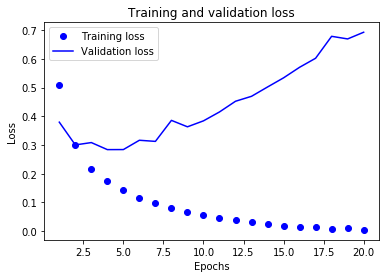

In [49]:
# 绘制训练损失和验证损失
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo' 表示蓝色圆点
plt.plot(epochs, loss, 'bo', label='Training loss')
# 'b' 表示蓝色实线
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

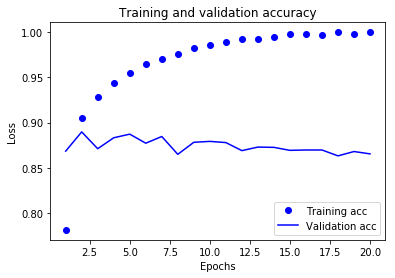

In [50]:
# 绘制训练精度和验证精度
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

显然上述过拟合！！！为了防止过拟合，你可以在 3 轮之后停止训练

In [53]:
# 从头开始重新训练一个模型
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
# 在测试集上的损失和精度
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25000/25000 [==============================] - 6s 220us/step - loss: 0.4783 - acc: 0.8272 1s - loss: 0.5081 -
Epoch 2/4
25000/25000 [==============================] - 4s 178us/step - loss: 0.2786 - acc: 0.9075 0s - loss: 0.2834 - acc: 0.906 - ETA: 0s - loss: 0.2824 - ac
Epoch 3/4
25000/25000 [==============================] - 5s 186us/step - loss: 0.2093 - acc: 0.9278 3s - loss: 0.2178 - - ETA: 2s 
Epoch 4/4
25000/25000 [==============================] - 9s 351us/step


[0.30490342072486876, 0.879]

In [54]:
# 使用训练好的网络在新数据上生成预测结果
pred = model.predict(x_test)
pred

array([[0.15765947],
       [0.99993944],
       [0.779925  ],
       ...,
       [0.1113606 ],
       [0.05763143],
       [0.4232023 ]], dtype=float32)

# 5 进一步的实验

通过以下实验，你可以确信前面选择的网络架构是非常合理的，虽然仍有改进的空间。
* 前面使用了两个隐藏层。你可以尝试使用一个或三个隐藏层，然后观察对验证精度和测试精度的影响。
* 尝试使用更多或更少的隐藏单元，比如 32 个、 64 个等。
* 尝试使用 mse 损失函数代替 binary_crossentropy。
* 尝试使用 tanh 激活（这种激活在神经网络早期非常流行）代替 relu。

下面是你应该从这个例子中学到的要点。
* 通常需要对原始数据进行大量预处理，以便将其转换为张量输入到神经网络中。单词序列可以编码为二进制向量，但也有其他编码方式。
* 带有`relu`激活的`Dense`层堆叠，可以解决很多种问题（包括情感分类），你可能会经常用到这种模型。
* 对于二分类问题（两个输出类别），网络的最后一层应该是只有一个单元并使用`sigmoid`激活的`Dense`层，网络输出应该是 0~1 范围内的标量，表示概率值。
* 对于二分类问题的`sigmoid`标量输出，你应该使用`binary_crossentropy`损失函数。
* 无论你的问题是什么， `rmsprop`优化器通常都是足够好的选择。这一点你无须担心。
* 随着神经网络在训练数据上的表现越来越好，模型最终会过拟合，并在前所未见的数据上得到越来越差的结果。一定要一直监控模型在训练集之外的数据上的性能。